In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
vaccine_df = pd.read_excel('./dataset/vaccine_1006-1007.xlsx', engine="openpyxl")

In [3]:
# 분석에 필요한 피처만 선택
vaccine_df = vaccine_df[['text', 'created_at', 'user_location']]
vaccine_df.head()

,text,created_at,user_location
0,@nothingbutnikki My rights are the same. I hav...,2021-10-06 23:59:59,"Brooklyn, NY"
1,I cried listen to konspirasi vaksin. If vaccin...,2021-10-06 23:59:59,NaN
2,BREAKING: Idaho lieutenant governor bans vacci...,2021-10-06 23:59:59,NaN
3,So many people still think that the vaccine st...,2021-10-06 23:59:59,NaN
4,Kyrie was doing ACID and smoking black n milds...,2021-10-06 23:59:59,NaN


In [4]:
# 코로나 백신 부작용목록 소문자화해서 리스트로 가져오기
f = open("./dataset/covid_side_effect_list.txt", "r")
covidList = f.read().lower().split("\n")
f.close()

In [5]:
# 모든백신-코로나백신 부작용 소문자화해서 리스트로 가져오기
f = open("./dataset/except_covid_side_effect_list.txt", "r")
exceptCovidList = f.read().lower().split("\n")
f.close()

In [6]:
# 데이터프레임에서 텍스트 : 소문자화
vaccine_df['text'] = vaccine_df['text'].astype('str')
vaccine_df['text'] = vaccine_df.text.apply(str.lower)

In [7]:
vaccine_df.head()

,text,created_at,user_location
0,@nothingbutnikki my rights are the same. i hav...,2021-10-06 23:59:59,"Brooklyn, NY"
1,i cried listen to konspirasi vaksin. if vaccin...,2021-10-06 23:59:59,NaN
2,breaking: idaho lieutenant governor bans vacci...,2021-10-06 23:59:59,NaN
3,so many people still think that the vaccine st...,2021-10-06 23:59:59,NaN
4,kyrie was doing acid and smoking black n milds...,2021-10-06 23:59:59,NaN


In [8]:
vaccineTextList = vaccine_df['text'].values

# Document Term Matrix의 column목록 [상위 ]
dtmColumnList = ['pfizer', 'moderna'] + covidList + exceptCovidList

### 부작용단어가 있으면 True, 없으면 False인 DTM 생성

In [9]:
# 부작용명이 있으면 True, 없으면 False

exist2DList = []
for i in tqdm(range(len(vaccineTextList))): # 각 문서
    existList = []
    for j in range(len(dtmColumnList)): # 각 단어
        if dtmColumnList[j] in vaccineTextList[i]:
            existList.append(True)
        else:
            existList.append(False)
    exist2DList.append(existList)

100%|█████████████████████████████████████████████████████████████████████████| 371972/371972 [14:32<00:00, 426.48it/s]


In [10]:
# Document Term Matrix 생성
dtm_df = pd.DataFrame(exist2DList, columns=dtmColumnList)
dtm_df.head()

,pfizer,moderna,headache,pyrexia,fatigue,chills,pain,dizziness,nausea,pain in extremity,...,band sensation,philadelphia chromosome positive,bleeding varicose vein,cystoid macular oedema,skin discharge,tonsillolith,enzyme level increased,red blood cell count abnormal,fear of disease,echovirus test
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 부작용단어-게시글의 수 카운트

In [11]:
pfizer_df = pd.DataFrame(sum(dtm_df.values), index=dtmColumnList, columns=['count'])

In [12]:
pfizer_df = pfizer_df[pfizer_df['count'] >= 5]

In [13]:
pfizer_df.to_excel("./dataset/text_count_result.xlsx")

In [49]:
# dtm_df에서 count < 5인 column 제거
dtm_df.drop(list(set(set(dtm_df.columns) - set(list(pfizer_df.index)))), inplace=True, axis=1)

### Threshold >= 2 이상인 게시글만 추출

In [14]:
merge_df = pd.DataFrame(np.sum(dtm_df.values, axis=1), columns=['count'])

In [15]:
len(np.where(merge_df["count"] >= 2)[0])

31242

In [16]:
postList = vaccine_df['text'][np.where(merge_df["count"] >= 2)[0]].values

### 영어 텍스트 전처리

In [17]:
# 데이터프레임 -> 리스트로 변환
def tolist(df):
    return [tuple(r) for r in df.to_numpy()]

# 리스트 -> 딕셔너리로 변환
def todict(list_tuple):    
    todict = {}
    for i in range(0,len(list_tuple)):
        todict[list_tuple[i][0]] = list_tuple[i][1]
    return todict

def getRankList(clean_list):
    from sklearn.feature_extraction.text import TfidfVectorizer

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(clean_list)

    terms = tfidf_vectorizer.get_feature_names()

    # TF-IDF 각 단어의 결과를 더함
    sums = tfidf_matrix.sum(axis=0)

    # 단어와 결과를 연결
    data = []
    for idx, term in enumerate(terms):
           data.append( (term, sums[0, idx] ))

    # 데이터프레임으로 변환, 내림차순 정렬 
    ranking_df = pd.DataFrame(data, columns=['term','rank'])
    ranking_df.sort_values('rank',inplace=True, ascending=False)
    
    # 리스트로 반환
    return tolist(ranking_df)

def textprocess(postList):
    import re
    postStr = ' '.join(postList)
    
    # 영어만 남기고 전부 제거
    only_english = re.sub('[^a-zA-Z]', ' ', postStr).split()
    
    from nltk.corpus import stopwords
    import nltk
    nltk.download('stopwords')
    
    # 불용어 제거
    stops = set(stopwords.words('english'))
    no_stops = [word for word in only_english if not word in stops]
    
    return no_stops
    
def showWordCloud(no_stops, limit=100):
    ranking_list = getRankList(no_stops)
    ranking_list[:limit]
    
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                          relative_scaling = 0.3,
                          background_color='white',
                          ).generate_from_frequencies(todict(ranking_list[:limit]))

    plt.figure(figsize=(16,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### Threshold >= 2 인 모든 게시글

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hyunc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


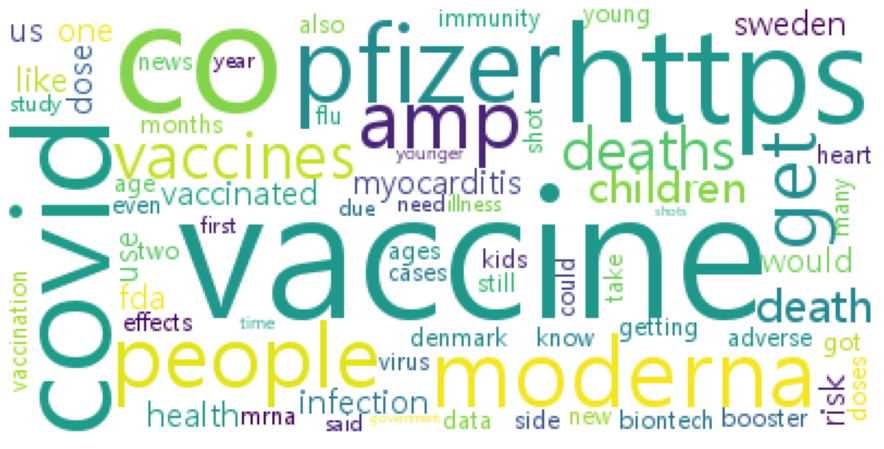

In [18]:
showWordCloud(textprocess(postList), 70)

### 사용자입력

병명입력 : pfizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hyunc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


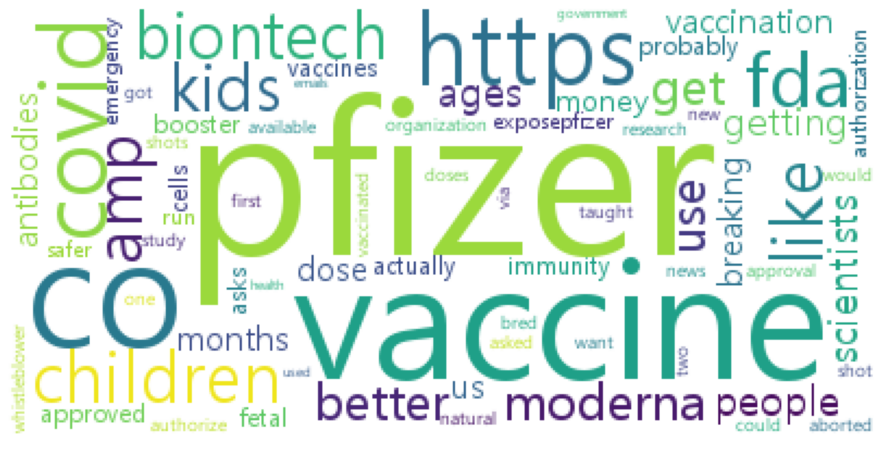

병명입력 : moderna


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hyunc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


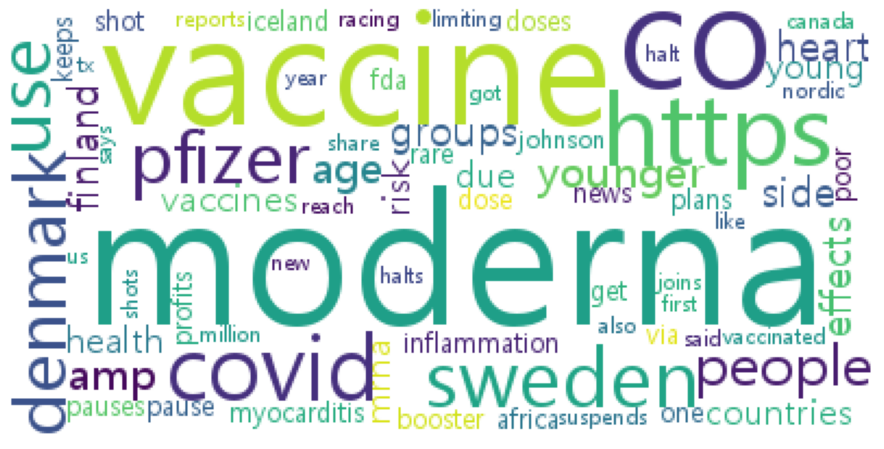

병명입력 : headache


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hyunc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


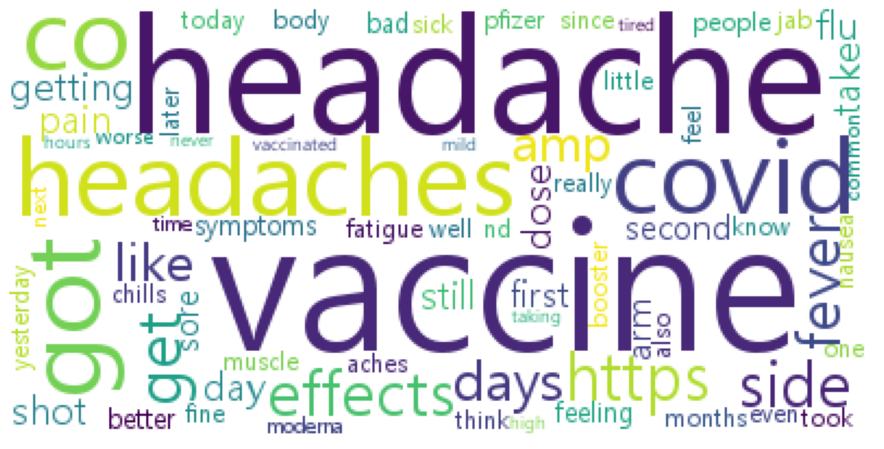

병명입력 : fatigue


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hyunc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


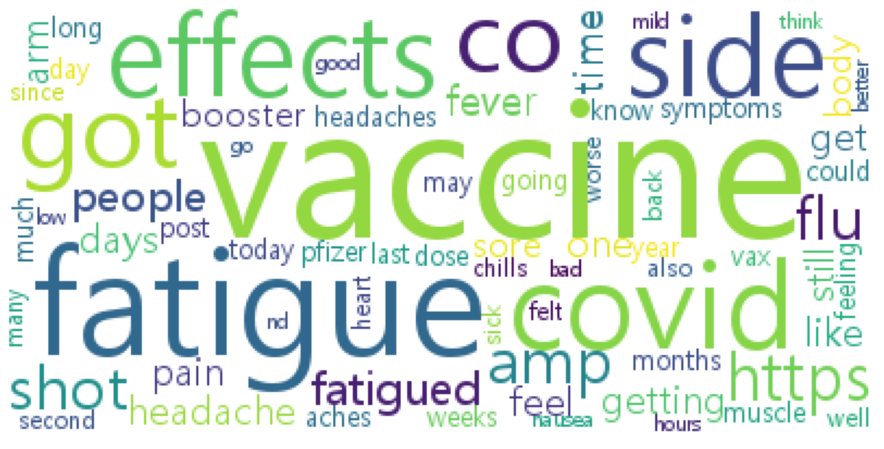

병명입력 : cough


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hyunc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


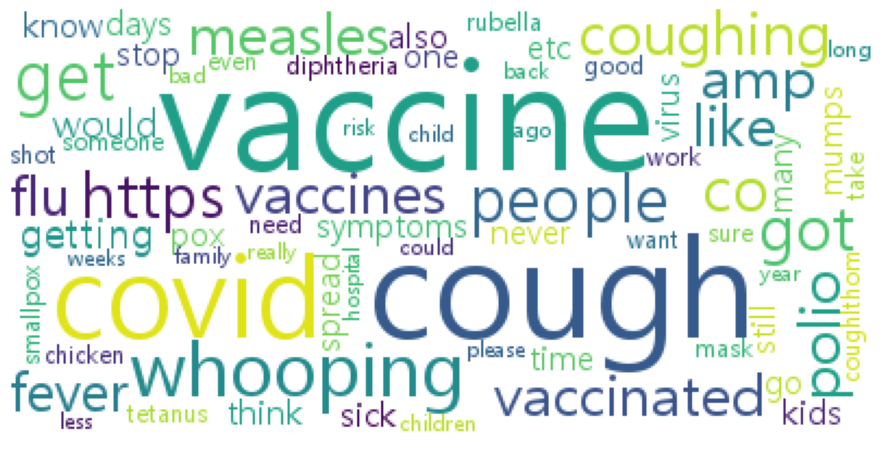

병명입력 : nausea


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hyunc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


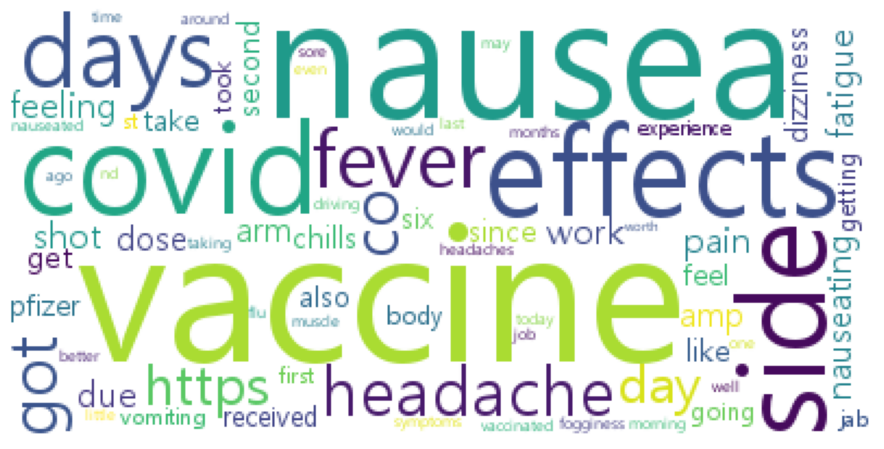

KeyboardInterrupt: Interrupted by user

In [19]:
while(True):
    disease = input('병명입력 : ')

    postList = vaccine_df['text'][np.where(dtm_df[disease] == True)[0]].values
    showWordCloud(textprocess(postList), 70)

### Cooccurrence 계산

In [51]:
from tqdm import tqdm
# 단어쌍의 빈도수를 저장할 dict
count_dict = {}

column_list = dtm_df.columns
word_length = len(column_list)

for doc_num in tqdm(range(len(dtm_df))):
    tmp = dtm_df.loc[doc_num]           # 단어 출현 빈도 데이터를 가져온다.
    for i, word1 in enumerate(column_list):
        if tmp[word1]:              # 첫번째 단어가 존재할 경우
            for j in range(i + 1, word_length):
                if tmp[column_list[j]]:              # 두번째 단어가 존재할 경우
                    count_dict[column_list[i], column_list[j]] = count_dict.get((column_list[i], column_list[j]), 0) + max(tmp[word1], tmp[column_list[j]])

count_dict

100%|█████████████████████████████████████████████████████████████████████████| 371972/371972 [10:57<00:00, 565.98it/s]


{('covid-19', 'protein c'): 8,
 ('moderna', 'inflammation'): 679,
 ('death', 'illness'): 548,
 ('investigation', 'tic'): 32,
 ('moderna', 'covid-19'): 2262,
 ('moderna', 'myocarditis'): 578,
 ('moderna', 'carditis'): 588,
 ('covid-19', 'myocarditis'): 376,
 ('covid-19', 'carditis'): 394,
 ('myocarditis', 'carditis'): 2493,
 ('mass', 'tic'): 282,
 ('death', 'shock'): 68,
 ('shock', 'tic'): 83,
 ('measles', 'rubella'): 223,
 ('covid-19', 'aura'): 145,
 ('pfizer', 'covid-19'): 4323,
 ('covid-19', 'tic'): 1581,
 ('measles', 'mumps'): 364,
 ('mumps', 'rubella'): 206,
 ('pfizer', 'moderna'): 1745,
 ('pfizer', 'tic'): 1124,
 ('moderna', 'tic'): 511,
 ('poisoning', 'murder'): 11,
 ('myocarditis', 'infection'): 142,
 ('infection', 'carditis'): 147,
 ('covid-19', 'death'): 1131,
 ('covid-19', 'murder'): 106,
 ('covid-19', 'inflammation'): 208,
 ('death', 'infection'): 576,
 ('covid-19', 'tinnitus'): 4,
 ('pfizer', 'death'): 421,
 ('pfizer', 'myocarditis'): 266,
 ('pfizer', 'pericarditis'): 69,
 

In [52]:
count_list = []

# count_list에 word1, word2, frequency 형태로 저장
for words in count_dict:
    count_list.append([words[0], words[1], count_dict[words]])

In [53]:
freq = 1
count_freq_list = []

for i in range(len(count_list)):
    if count_list[i][2] >= freq:
        count_freq_list.append(count_list[i])

In [54]:
len(count_freq_list)

3846

In [55]:
# 단어쌍 동시 출현 빈도를 DataFrame 형식으로 만든다.
coo_df = pd.DataFrame(count_freq_list, columns=["word1", "word2", "frequency"])
coo_df = coo_df.sort_values(by=['frequency'], ascending=False)
coo_df = coo_df.reset_index(drop=True)

# 단어쌍 결과를 excel로 저장
coo_df.to_excel('./dataset/cooccurrence.xlsx')
coo_df.head()

,word1,word2,frequency
0,pfizer,covid-19,4323
1,myocarditis,carditis,2493
2,moderna,covid-19,2262
3,pfizer,moderna,1745
4,covid-19,tic,1581


### 그래프

In [127]:
import networkx as nx
import operator
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import community as community_louvain
import matplotlib.cm as cm

# 폰트설정, 한글깨짐방지
fm._rebuild()
font_fname = 'C:/Users/hyunc/AppData/Local/Microsoft/Windows/Fonts/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_fname).get_name()

In [108]:
coo_df = pd.read_excel('./dataset/cooccurrence.xlsx', engine="openpyxl")

In [109]:
coo_df.head()

,Unnamed: 0,word1,word2,frequency
0,0,pfizer,covid-19,4323
1,1,myocarditis,carditis,2493
2,2,moderna,covid-19,2262
3,3,pfizer,moderna,1745
4,4,covid-19,tic,1581


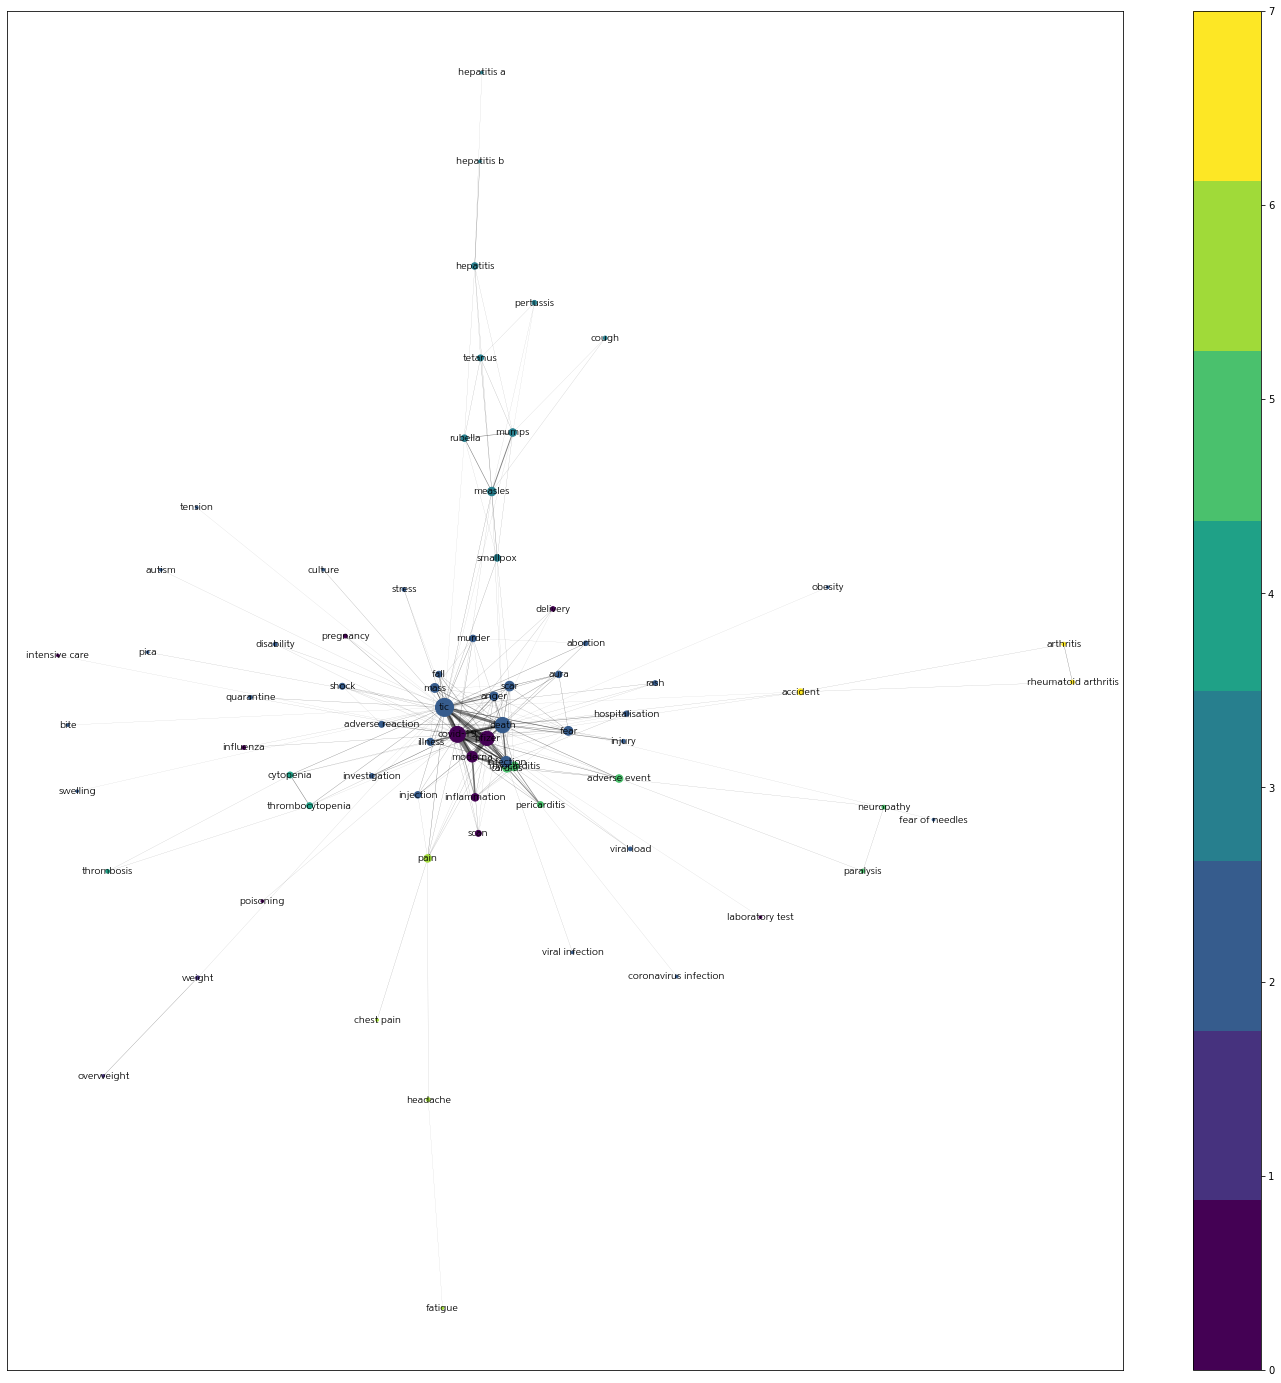

커뮤니티 1 
 ['pfizer', 'covid-19', 'moderna', 'inflammation', 'pregnancy', 'scan', 'influenza', 'delivery', 'poisoning', 'intensive care', 'laboratory test'] 

커뮤니티 2 
 ['weight', 'overweight'] 

커뮤니티 3 
 ['tic', 'death', 'infection', 'illness', 'anger', 'scar', 'mass', 'fear', 'fall', 'injury', 'adverse reaction', 'hospitalisation', 'aura', 'investigation', 'murder', 'abortion', 'injection', 'quarantine', 'stress', 'shock', 'culture', 'rash', 'viral load', 'disability', 'pica', 'viral infection', 'autism', 'coronavirus infection', 'fear of needles', 'bite', 'obesity', 'swelling', 'tension'] 

커뮤니티 4 
 ['measles', 'mumps', 'rubella', 'smallpox', 'hepatitis', 'hepatitis b', 'tetanus', 'cough', 'pertussis', 'hepatitis a'] 

커뮤니티 5 
 ['thrombocytopenia', 'cytopenia', 'thrombosis'] 

커뮤니티 6 
 ['myocarditis', 'carditis', 'pericarditis', 'adverse event', 'paralysis', 'neuropathy'] 

커뮤니티 7 
 ['pain', 'chest pain', 'headache', 'fatigue'] 

커뮤니티 8 
 ['arthritis', 'rheumatoid arthritis', 'accident

In [138]:
# 빈도수 설정
frequency = 30


"""
차수(Degree) 계산
"""
# 그래프 생성
G = nx.Graph()

# 거리가 threshold 초과 단어쌍에 대해서만 edge 생성
for idx in range((len(np.where(coo_df['frequency'] >= frequency)[0]))):
    G.add_edge(coo_df['word1'][idx], coo_df['word2'][idx], weight=int(coo_df['frequency'][idx]))
    
# Degree Centrality 계산
dgr = nx.degree_centrality(G)

# 내림차순 정렬
sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)

# 노드생성, degree에 따라 노드 크기 결정
for idx in range(len(sorted_dgr)):
    G.add_node(sorted_dgr[idx][0], nodesize=sorted_dgr[idx][1])


"""
그래프 클러스터링 (louvain)
"""

# 클러스터(파티션) 계산
partition = community_louvain.best_partition(G)

# 레이아웃 설정
pos = nx.spring_layout(G)

# 클러스터(파티션)에 따른 색상 결정
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


"""
그래프 시각화
"""

# 그래프 크기 설정
fig = plt.figure(figsize=(25,25))

# 노드 및 엣지크기 설정
sizes = [G.nodes[node]['nodesize'] * 500 for node in G] # 노드사이즈
edge_wts = [0.0025 * edge[2] for edge in G.edges(data = 'weight')] # 엣지사이즈

# 그래프 시각화
im = nx.draw_networkx_nodes(G, pos, cmap=cmap, node_size=sizes, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5, width=edge_wts)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="BLACK", font_family=fontprop)
plt.colorbar(im)
plt.show(block=False)

# 커뮤니티 텍스트 출력
count = 0    
nodes_list = []
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nodes_list.append(list_nodes)
    print('커뮤니티', int(count), '\n',list_nodes, '\n')